## Predict air quality in Madrid with Fedot.Industrial

Dataset published on Kaggle Its input data consists in measurements of the **level of sulphur dioxide, carbon monoxide and nitric oxide**. Time series correspond to hourly values measured during a week. The target value is the **weekly averaged PM10**. The final dataset includes 6922 3-dimensional time series with a length of 168. The training dataset is composed of randomly selected 70% of the samples, whereas the remaining 30% forms the testing dataset.
Link to the dataset - https://www.kaggle.com/datasets/decide-soluciones/air-quality-madrid

In [1]:
import pandas as pd

from fedot_ind.api.utils.path_lib import PROJECT_PATH
from fedot_ind.tools.loader import DataLoader
from examples.example_utils import init_input_data

In [2]:
from cases.utils import ts_regression_setup
dataset_name = 'MadridPM10Quality-no-missing'
OperationTypesRepository, tuning_params, data_path, experiment_setup, model_dict = ts_regression_setup()
experiment_setup['output_folder'] = f'./{dataset_name}/results_of_experiment'

Now we must download the dataset. It could be done by using `DataReader` class that implemented as attribute of `Framework` class. This class firstly tries to read the data from local project folder `data_path` and then if it is not possible, it downloads the data from the UCR/UEA archive. The data will be saved in the `data` folder.

In [3]:
_, train_data, test_data = DataLoader(dataset_name=dataset_name).read_train_test_files(
            dataset_name=dataset_name,
            data_path=data_path)

2023-10-03 17:49:36,892 - Reading data from D:\WORK\Repo\Industiral\IndustrialTS/examples/data/MadridPM10Quality-no-missing


In [4]:
input_data = init_input_data(train_data[0], train_data[1], task=tuning_params['task'])
val_data = init_input_data(test_data[0], test_data[1], task=tuning_params['task'])

Lets check our data.

In [5]:
input_data.features.shape

(4845, 3, 168)

Lets visualise our predictors.

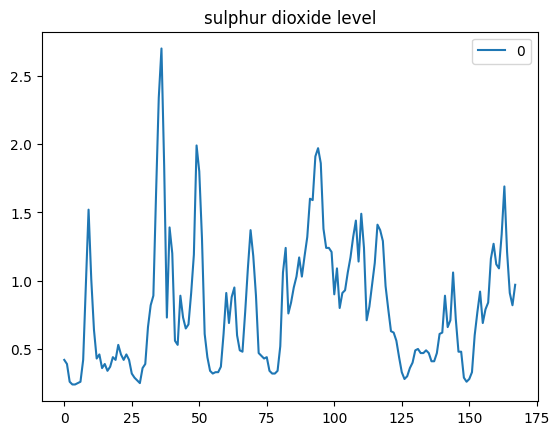

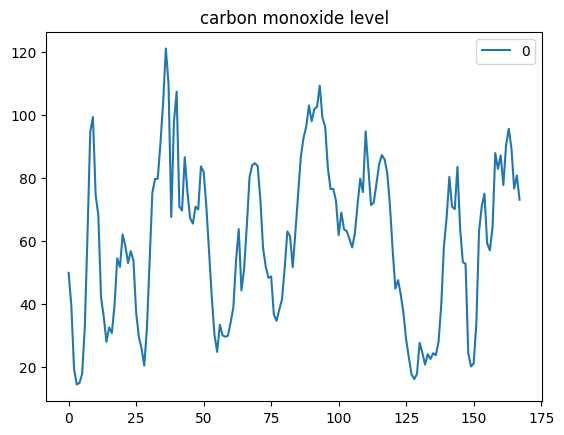

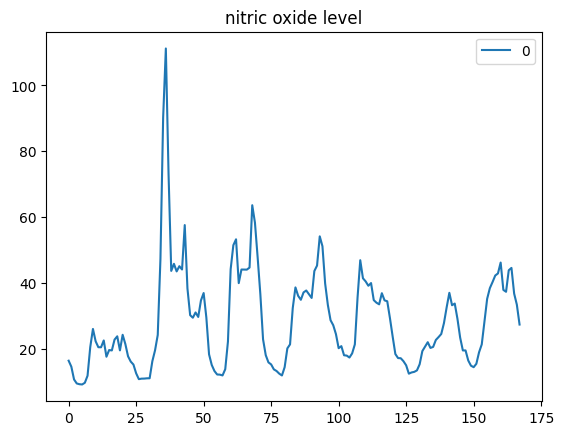

In [6]:
from matplotlib import pyplot as plt
pd.DataFrame(input_data.features[1, 0, :]).plot(title='sulphur dioxide level')
pd.DataFrame(input_data.features[1, 1, :]).plot(title='carbon monoxide level')
pd.DataFrame(input_data.features[1, 2, :]).plot(title='nitric oxide level')
plt.show()

Next steps are quite straightforward. We need to fit the model and then predict the values for the test data just like for any other model in sklearn.

At the `fit` stage Framework will transform initial time series data into features dataframe and will train regression model.

In [ ]:
from cases.utils import evaluate_industrial_model
metric_dict = evaluate_industrial_model(train_data,test_data)

At the end of the experiment we can obtain the desired metric values using `calculate_regression_metric` method. Now there are five available metrics for classification task:
- `explained_variance_score`
- `max_error`
- `mean_absolute_error`
- `mean_squared_error`
- `d2_absolute_error_score`.
- `median_absolute_error`
- `r2_score`

In [ ]:
df_baseline = pd.concat([x for x in metric_dict.values()],axis=1)
df_baseline.columns = list(metric_dict.keys())
df_baseline = df_baseline.T
df_baseline.sort_values(by='root_mean_squared_error:')
best_baseline = df_baseline.sort_values('root_mean_squared_error:')['root_mean_squared_error:'].iloc[0]

## Could it be done better? Tuning approach

In [ ]:
from cases.utils import finetune
finetune(tuning_params, model_dict, train_data, test_data, val_data, input_data)

In [ ]:
df_tuned = pd.concat([x for x in metric_dict.values()], axis=0).T
df_tuned.columns = list(metric_dict.keys())
df_tuned.T.sort_values('root_mean_squared_error:')

In [ ]:
df_tuned.T.sort_values('root_mean_squared_error:')['model_params'].iloc[0]

In [ ]:
best_tuned = df_tuned.T.sort_values('root_mean_squared_error:')['root_mean_squared_error:'].iloc[0]

## Even better? AutoML approach

In [ ]:
from cases.utils import evaluate_automl
metric_dict, model_list = evaluate_automl(runs=3)

In [ ]:
df_automl = pd.concat([x for x in metric_dict.values()],axis=0).T
df_automl.columns = list(metric_dict.keys())
df_automl = df_automl.T
df_automl.sort_values('root_mean_squared_error:')

## Compare with State of Art (SOTA) models

In [ ]:
from cases.utils import sota_compare
sota_compare(data_path,dataset_name, best_baseline,best_tuned,df_automl)